# Backbone atoms (allatom without side-chains)

Parameters:

* $c$ -- cutoff
* $b$ -- number of bins for each pair of atom types
* $r$ -- topological distance to skipping neighbouring atoms

In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
import re
from multiprocessing import Pool, TimeoutError
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from scripts import data_mining
from scripts.data_mining import (OneHotImputer,
                                 load_pickled_dataset, dataset_binary_filename, select_subset,
                                 remove_zero_features, train_test_split, one_hot_from_scores,
                                 scoring_results)

In [2]:
mat_file_patterns = []

for sigma in [0]:
    for num_bins in [7, 10, 15, 20, 25, 30, 35]:
        for cutoff in [5, 6, 7, 7.5, 8]:
            for radius in [0, 1, 2]:
                mat_file_patterns.append(
                    '*backboneatoms-s{}-b{}-c{}-r{}--residue_dependent--skip_errors.mat'.format(sigma, num_bins, cutoff, radius)
                )

In [3]:
checksums = ['8360e499006b09a5c2768cbbd2e09ecf']

In [4]:
def get_natives(scores):
    natives = np.array([bool(re.match('T0...\.pdb', x.split('/')[-1])) for x in scores.index])
    return pd.Series(data=natives, index=scores.index)

In [5]:
models = [
    ("Normalizer + Logistic",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("MaxAbsScaler + Logistic",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("Normalizer + Ridge",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X)),
    ("MaxAbsScaler + Ridge",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X))
]

In [6]:
scores = load_pickled_dataset(dataset_binary_filename(mat_file_patterns[-10], checksums[0], 'binaries'))[1]
scores = select_subset(scores, scores, '^.*CASP([5-9]|10)/T..../.*$')[1]
indices = scores.index.sort_values().copy()

In [7]:
results_train = {}
results_val = {}

In [8]:
def compute_results(args):
    try:
        mat_file_pattern, indices = args

        for checksum in checksums:
            try:
                X, scores, _ = load_pickled_dataset(
                    dataset_binary_filename(mat_file_pattern, checksum, 'binaries')
                )
                break
            except:
                X, scores = None, None

        if X is None:
            print(mat_file_pattern, '\tError: Dataset not found', flush=True)
            return mat_file_pattern, None

        scores['__temp_index'] = range(scores.shape[0])
        scores = scores.loc[indices]
        if pd.isnull(scores['__temp_index']).sum():
            print(mat_file_pattern, '\tError: Got smaller dataset', flush=True)
            return mat_file_pattern, None

        X = X[scores['__temp_index'].values]
        del scores['__temp_index']

        old_shape = X.shape
        X, nonzero_features = remove_zero_features(X)
        print(mat_file_pattern, '\tX.size: {},\t{} -> {}'.format(X.size, old_shape, X.shape), flush=True)

        train_blocks, train_idx, val_blocks, val_idx = train_test_split(one_hot_from_scores(scores),
                                                                        test_ratio=0.4, seed=17)
        X_train = X[train_idx]
        X_val = X[val_idx]
        del X
        scores_train = scores[train_idx]
        scores_val = scores[val_idx]

        results_train = {}
        results_val = {}

        for model_name, model, train, predicted_score in models:

            ### Train
            train(model, X_train, scores[train_idx])

            ### Results on training set
            results_train[model_name + ' + native'], _ = scoring_results(X_train, scores_train,
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)

            results_train[model_name], _ = scoring_results(X_train[~get_natives(scores_train).values],
                                                           scores_train[~get_natives(scores_train).values],
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)
            ### Results on validation set
            results_val[model_name + ' + native'], _ = scoring_results(X_val, scores_val,
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

            results_val[model_name], _ = scoring_results(X_val[~get_natives(scores_val).values],
                                                         scores_val[~get_natives(scores_val).values],
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

        return mat_file_pattern, (results_train, results_val)
    except Exception as e:
        print(mat_file_pattern, '\tError: Exception', e, flush=True)
        return mat_file_pattern, None

In [15]:
pool = Pool(processes=4)
pool_result = pool.imap_unordered(compute_results, [(mat_file_pattern, indices)
                                       for mat_file_pattern in mat_file_patterns
                                       if mat_file_pattern not in results_train.keys()])
pool.close()

In [18]:
returned = []

try:
    while True:
        returned.append(pool_result.next(timeout=0))
except TimeoutError:
    print('Timeout')
except StopIteration:
    print('Done')

for mat_file_pattern, res in returned:
    if res:
        results_train[mat_file_pattern], results_val[mat_file_pattern] = res

len(returned), len([x for x in returned if x[1]])

Done


(0, 0)

## Test

In [19]:
params = ['b', 'c', 'r']

In [40]:
def mean_top1_score(scores):
    return scores['GDT-TS-score']['Mean score for top 1']

def correlation_score(scores):
    return -scores['GDT-TS-score'][['Mean Pearson', 'Mean Spearman']].mean()

def summary(results):
    records = []
    for quality_criterion in [mean_top1_score, correlation_score]:
        for model in sorted(list(results.items())[0][1].keys()):
            benchmark = data_mining.generate_benchmark(results, quality_criterion)
            best_dataset = benchmark[model].argmax()
            records.append((best_dataset,
                            model + ' + ' + quality_criterion.__name__,
                            results[best_dataset][model]['GDT-TS-score']))
    metrics = list(list(results.values())[-20].values())[0].index
    df = pd.concat([x[2].loc[metrics] for x in records], axis=1)
    df.columns = [x[1] for x in records]
    df.loc['The best dataset'] = [x[0] for x in records]
    return df

def plot_results(results, model, quality_criterion, params, **kwargs):
    benchmark = data_mining.generate_benchmark(results, quality_criterion)
    data_mining.plot_heatmaps(benchmark, model, params, **kwargs)

    print('The best:\n{}'.format(benchmark[model].argmax()))
    data_mining.display(results[benchmark[model].argmax()][model])

In [41]:
df = summary(results_val)
data_mining.display(df.iloc[:, [c.split(' + ')[-2] == 'native' for c in df.columns]].T)
data_mining.display(df.iloc[:, [c.split(' + ')[-2] != 'native' for c in df.columns]].T)

Mean rank of the native  \
MaxAbsScaler + Logistic + native + mean_top1_score                 11.9602   
MaxAbsScaler + Ridge + native + mean_top1_score                     48.146   
Normalizer + Logistic + native + mean_top1_score                   9.38938   
Normalizer + Ridge + native + mean_top1_score                       30.354   
MaxAbsScaler + Logistic + native + correlation_...                 10.2566   
MaxAbsScaler + Ridge + native + correlation_score                  39.5619   
Normalizer + Logistic + native + correlation_score                 6.36283   
Normalizer + Ridge + native + correlation_score                    25.3274   

                                                        Top 1     Top 5  \
MaxAbsScaler + Logistic + native + mean_top1_score   0.535398  0.685841   
MaxAbsScaler + Ridge + native + mean_top1_score     0.0840708  0.221239   
Normalizer + Logistic + native + mean_top1_score     0.526549  0.721239   
Normalizer + Ridge + native + mean_top1_score        0.230088  0.384956   
MaxAbsScaler + Logistic + native + correlation_...   0.402655  0.646018   
MaxAbsScaler + Ridge + native + correlation_score    0.119469  0.243363   
Normalizer + Logistic + native + correlation_score   0.455752  0.774336   
Normalizer + Ridge + native + correlation_score      0.199115  0.442478   

                                                   Mean score for top 1  \
MaxAbsScaler + Logistic + native + mean_top1_score             0.793188   
MaxAbsScaler + Ridge + native + mean_top1_score                0.561243   
Normalizer + Logistic + native + mean_top1_score               0.798911   
Normalizer + Ridge + native + mean_top1_score                  0.616828   
MaxAbsScaler + Logistic + native + correlation_...             0.696819   
MaxAbsScaler + Ridge + native + correlation_score              0.559133   
Normalizer + Logistic + native + correlation_score             0.713508   
Normalizer + Ridge + native + correlation_score                0.588601   

                                                   Mean loss score  \
MaxAbsScaler + Logistic + native + mean_top1_score        0.206812   
MaxAbsScaler + Ridge + native + mean_top1_score           0.438757   
Normalizer + Logistic + native + mean_top1_score          0.201089   
Normalizer + Ridge + native + mean_top1_score             0.383172   
MaxAbsScaler + Logistic + native + correlation_...        0.303181   
MaxAbsScaler + Ridge + native + correlation_score         0.440867   
Normalizer + Logistic + native + correlation_score        0.286492   
Normalizer + Ridge + native + correlation_score           0.411399   

                                                   Mean Pearson Mean Spearman  \
MaxAbsScaler + Logistic + native + mean_top1_score    -0.216858      -0.13092   
MaxAbsScaler + Ridge + native + mean_top1_score       -0.371142     -0.298266   
Normalizer + Logistic + native + mean_top1_score      -0.147575     -0.109503   
Normalizer + Ridge + native + mean_top1_score         -0.537014     -0.419734   
MaxAbsScaler + Logistic + native + correlation_...    -0.249391     -0.169737   
MaxAbsScaler + Ridge + native + correlation_score     -0.398967     -0.322555   
Normalizer + Logistic + native + correlation_score    -0.283598     -0.278689   
Normalizer + Ridge + native + correlation_score       -0.559485     -0.447255   

                                                                                     The best dataset  
MaxAbsScaler + Logistic + native + mean_top1_score  *backboneatoms-s0-b20-c7-r2--residue_dependent...  
MaxAbsScaler + Ridge + native + mean_top1_score     *backboneatoms-s0-b30-c6-r1--residue_dependent...  
Normalizer + Logistic + native + mean_top1_score    *backboneatoms-s0-b30-c5-r0--residue_dependent...  
Normalizer + Ridge + native + mean_top1_score       *backboneatoms-s0-b30-c6-r2--residue_dependent...  
MaxAbsScaler + Logistic + native + correlation_...  *backboneatoms-s0-b7-c7-r0--residue_dependent-...  
MaxAbsScale

Mean rank of the native  \
MaxAbsScaler + Logistic + mean_top1_score                   120.345   
MaxAbsScaler + Ridge + mean_top1_score                      104.142   
Normalizer + Logistic + mean_top1_score                     111.385   
Normalizer + Ridge + mean_top1_score                        93.9513   
MaxAbsScaler + Logistic + correlation_score                 106.133   
MaxAbsScaler + Ridge + correlation_score                       99.5   
Normalizer + Logistic + correlation_score                   84.7257   
Normalizer + Ridge + correlation_score                      79.4381   

                                                  Top 1      Top 5  \
MaxAbsScaler + Logistic + mean_top1_score    0.00442478  0.0309735   
MaxAbsScaler + Ridge + mean_top1_score       0.00442478  0.0353982   
Normalizer + Logistic + mean_top1_score      0.00442478  0.0442478   
Normalizer + Ridge + mean_top1_score                  0  0.0221239   
MaxAbsScaler + Logistic + correlation_score  0.00884956  0.0486726   
MaxAbsScaler + Ridge + correlation_score      0.0176991  0.0442478   
Normalizer + Logistic + correlation_score     0.0176991  0.0530973   
Normalizer + Ridge + correlation_score       0.00442478  0.0176991   

                                            Mean score for top 1  \
MaxAbsScaler + Logistic + mean_top1_score               0.496347   
MaxAbsScaler + Ridge + mean_top1_score                  0.505963   
Normalizer + Logistic + mean_top1_score                  0.51035   
Normalizer + Ridge + mean_top1_score                      0.4982   
MaxAbsScaler + Logistic + correlation_score             0.466557   
MaxAbsScaler + Ridge + correlation_score                 0.49718   
Normalizer + Logistic + correlation_score               0.461242   
Normalizer + Ridge + correlation_score                  0.475566   

                                            Mean loss score Mean Pearson  \
MaxAbsScaler + Logistic + mean_top1_score           0.14383    -0.132176   
MaxAbsScaler + Ridge + mean_top1_score             0.134214    -0.344713   
Normalizer + Logistic + mean_top1_score            0.129827    -0.166594   
Normalizer + Ridge + mean_top1_score               0.141977    -0.499286   
MaxAbsScaler + Logistic + correlation_score         0.17362    -0.218537   
MaxAbsScaler + Ridge + correlation_score           0.142997    -0.386888   
Normalizer + Logistic + correlation_score          0.178935    -0.266593   
Normalizer + Ridge + correlation_score             0.164611    -0.552658   

                                            Mean Spearman  \
MaxAbsScaler + Logistic + mean_top1_score      -0.0840175   
MaxAbsScaler + Ridge + mean_top1_score          -0.279631   
Normalizer + Logistic + mean_top1_score         -0.144853   
Normalizer + Ridge + mean_top1_score            -0.393372   
MaxAbsScaler + Logistic + correlation_score     -0.160656   
MaxAbsScaler + Ridge + correlation_score         -0.31809   
Normalizer + Logistic + correlation_score       -0.271281   
Normalizer + Ridge + correlation_score           -0.44297   

                                                                              The best dataset  
MaxAbsScaler + Logistic + mean_top1_score    *backboneatoms-s0-b30-c7.5-r2--residue_depende...  
MaxAbsScaler + Ridge + mean_top1_score       *backboneatoms-s0-b30-c6-r0--residue_dependent...  
Normalizer + Logistic + mean_top1_score      *backboneatoms-s0-b20-c5-r2--residue_dependent...  
Normalizer + Ridge + mean_top1_score         *backboneatoms-s0-b30-c5-r1--residue_dependent...  
MaxAbsScaler + Logistic + correlation_score  *backboneatoms-s0-b10-c7.5-r2--residue_depende...  
MaxAbsScaler + Ridge + correlation_score     *backboneatoms-s0-b25-c7.5-r2--residue_depende...  
Normalizer + Logistic + correlation_score    *backboneatoms-s0-b10-c8-r2--residue_dependent...  
Normalizer + Ridge + correlation_score       *backboneatoms-s0-b30-c8-r0--residue_dependent...

In [22]:
df2 = data_mining.generate_benchmark(results_val, lambda scores: scores.ix['Top 1', 'RMSD'])
[p for p in set(df2.columns) - set(list(results_val.items())[0][1].keys()) if len(df2[p].unique()) > 1]

['r', 'b', 'c']

### Classification

#### Row normalization

##### Mean score for top 1

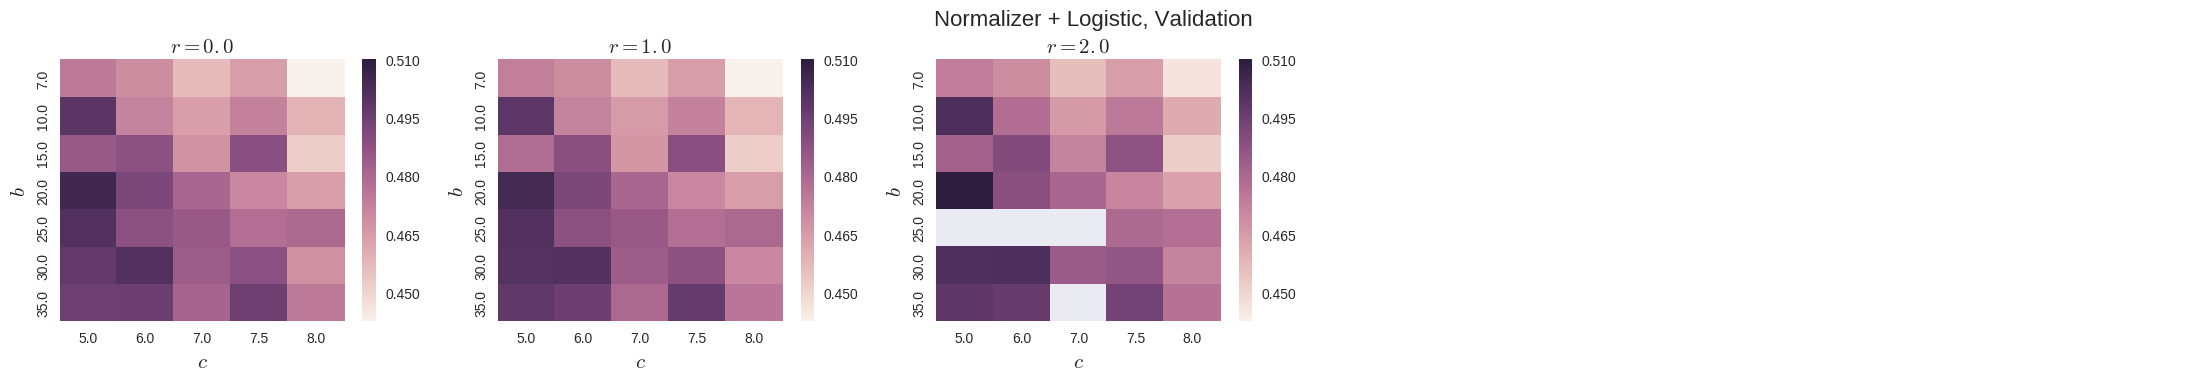

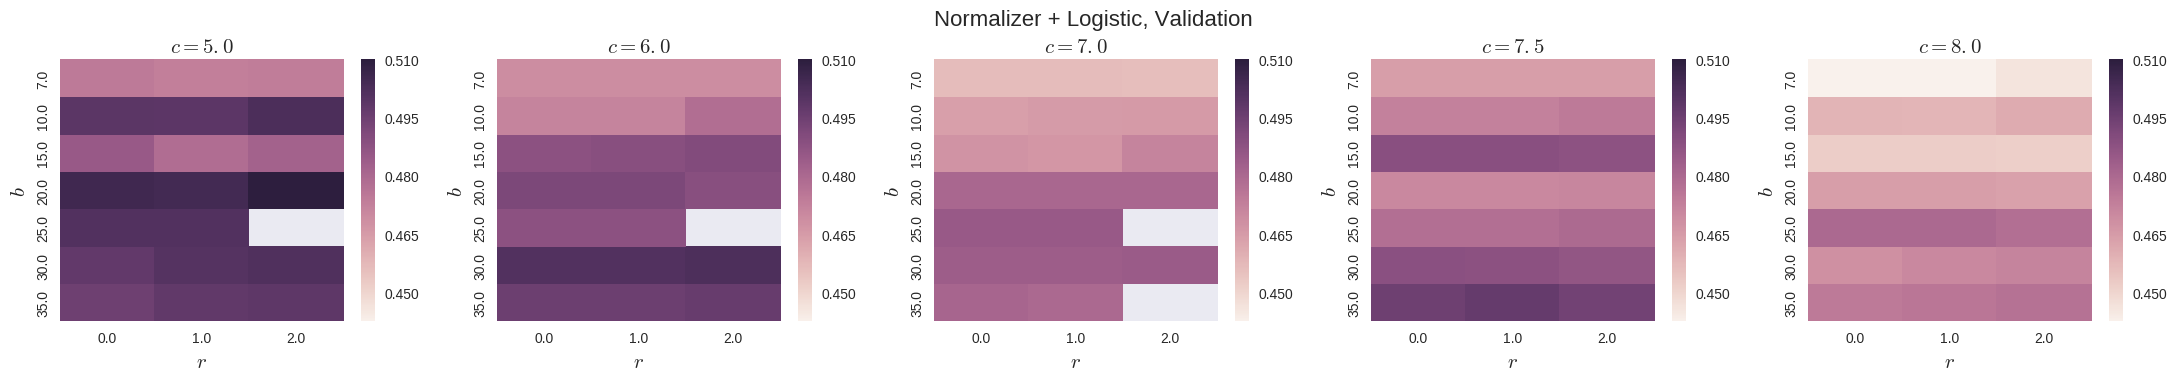

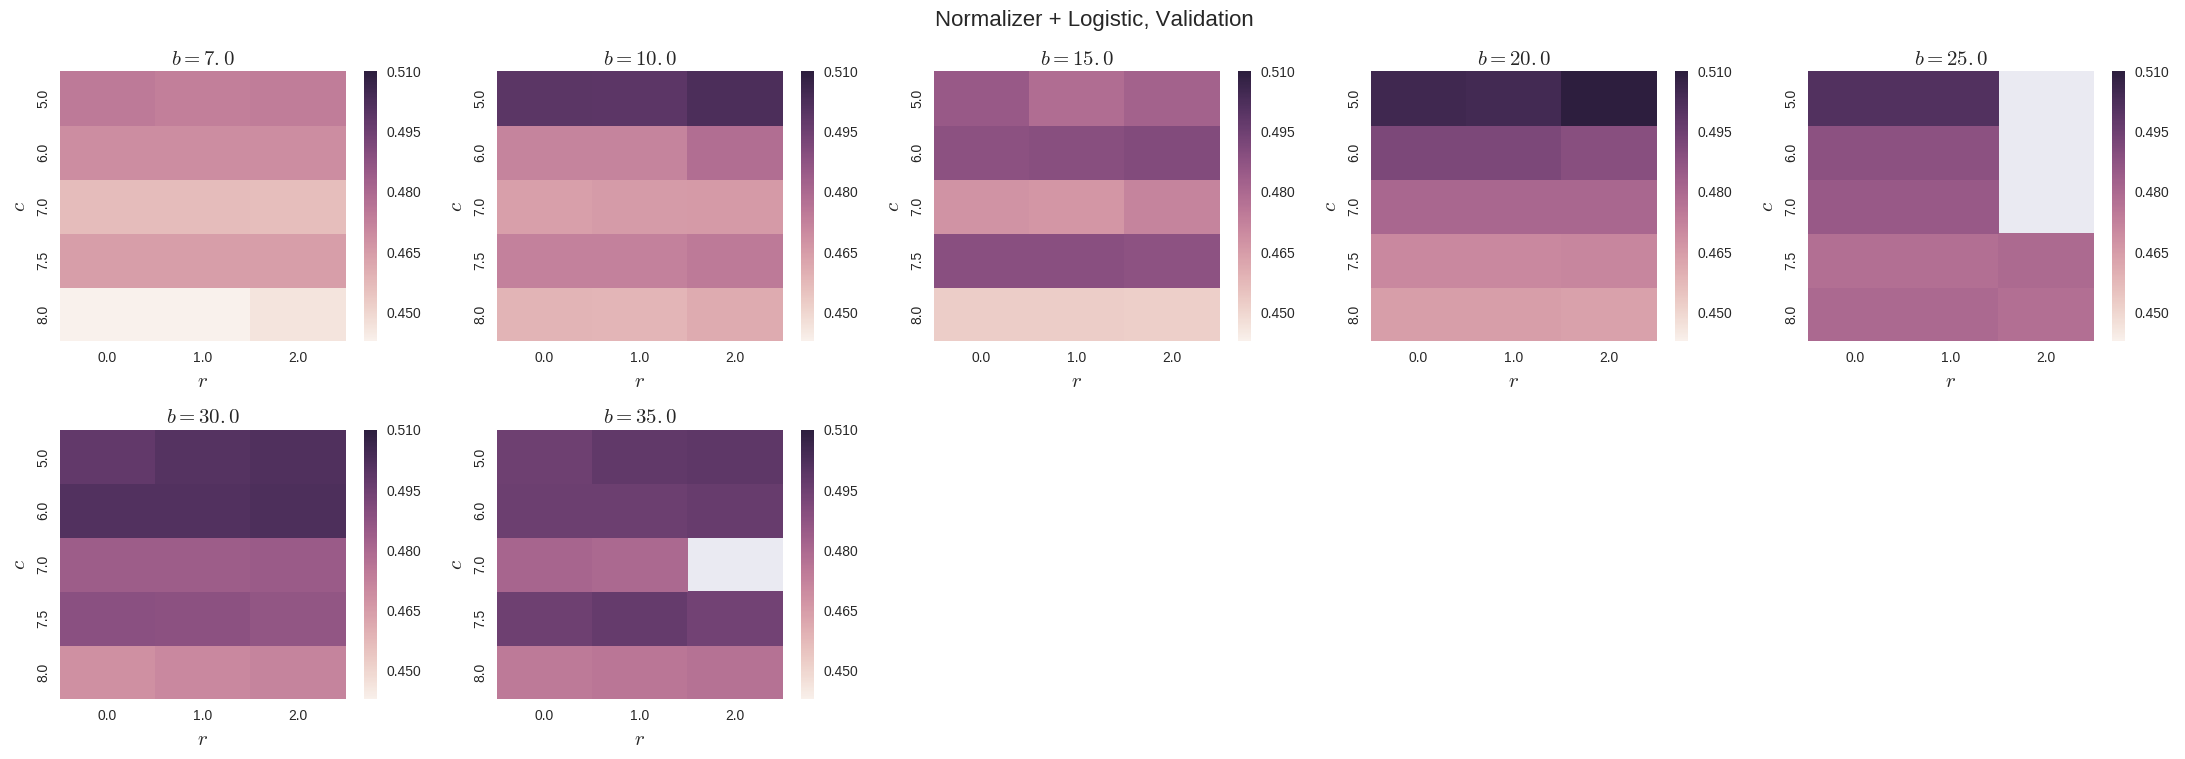

The best:
*backboneatoms-s0-b20-c5-r2--residue_dependent--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    110.239    118.655      107.487      111.385   
Top 1                    0.0265487  0.0176991    0.0176991   0.00442478   
Top 5                    0.0707965  0.0442478    0.0486726    0.0442478   
Mean score for top 1       8.13585   0.574152     0.474668      0.51035   
Mean loss score           -5.50925   0.138453     0.134621     0.129827   
Mean Pearson              0.191322  -0.146906    -0.173173    -0.166594   
Mean Spearman             0.182823   -0.11383    -0.156356    -0.144853   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      104.686        210.186            86.7699   
Top 1                     0.00884956              0          0.0265487   
Top 5                      0.0530973              0          0.0884956   
Mean score for top 1        0.370658        8.13585           0.595205   
Mean loss score             0.105764        55.6992           0.159104   
Mean Pearson               -0.189036       0.191322            -0.2047   
Mean Spearman              -0.176059       0.182796          -0.218318   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                98.8142                98.7035   
Top 1                                0.0265487              0.0309735   
Top 5                                0.0973451              0.0752212   
Mean score for top 1                  0.496669               0.536804   
Mean loss score                       0.236138               0.222046   
Mean Pearson                         -0.209962              -0.214514   
Mean Spearman                        -0.234584              -0.241205   

                        GDT-HA-score-backwards  
Mean rank of the native                100.562  
Top 1                                0.0309735  
Top 5                                0.0884956  
Mean score for top 1                  0.389281  
Mean loss score                       0.214073  
Mean Pearson                         -0.220717  
Mean Spearman                        -0.246789

In [23]:
plot_results(results_val,
             'Normalizer + Logistic', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1.1)

### Regression

#### Row normalization

##### Correlation score

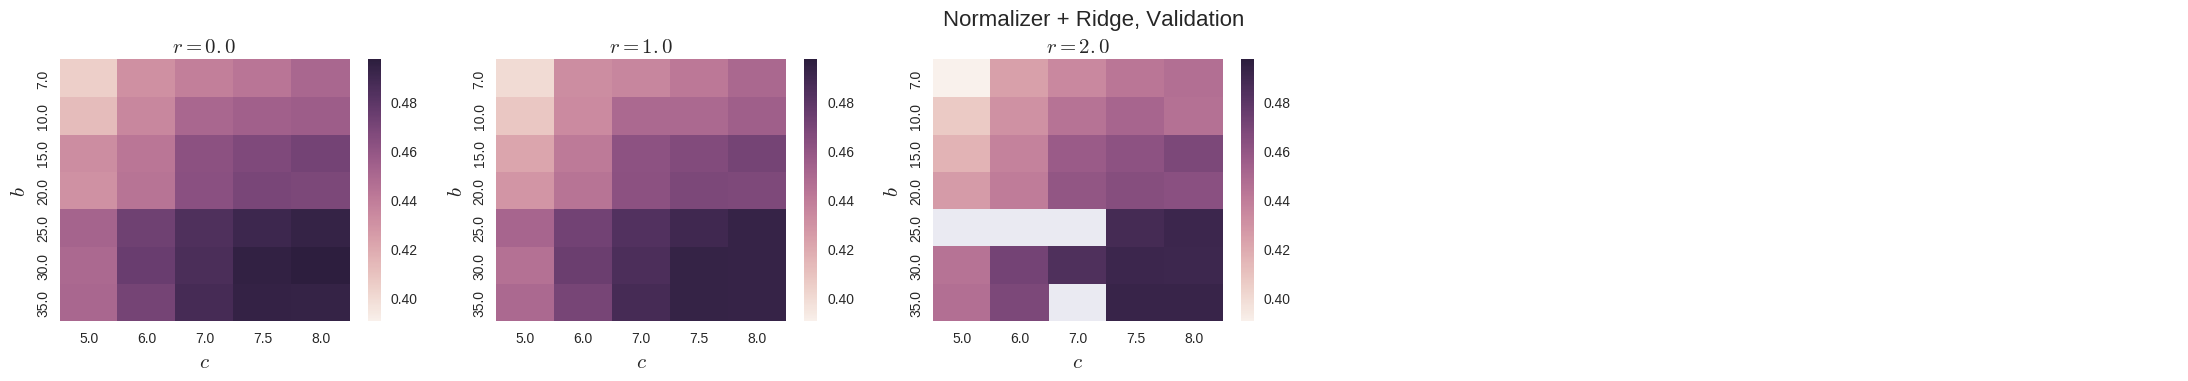

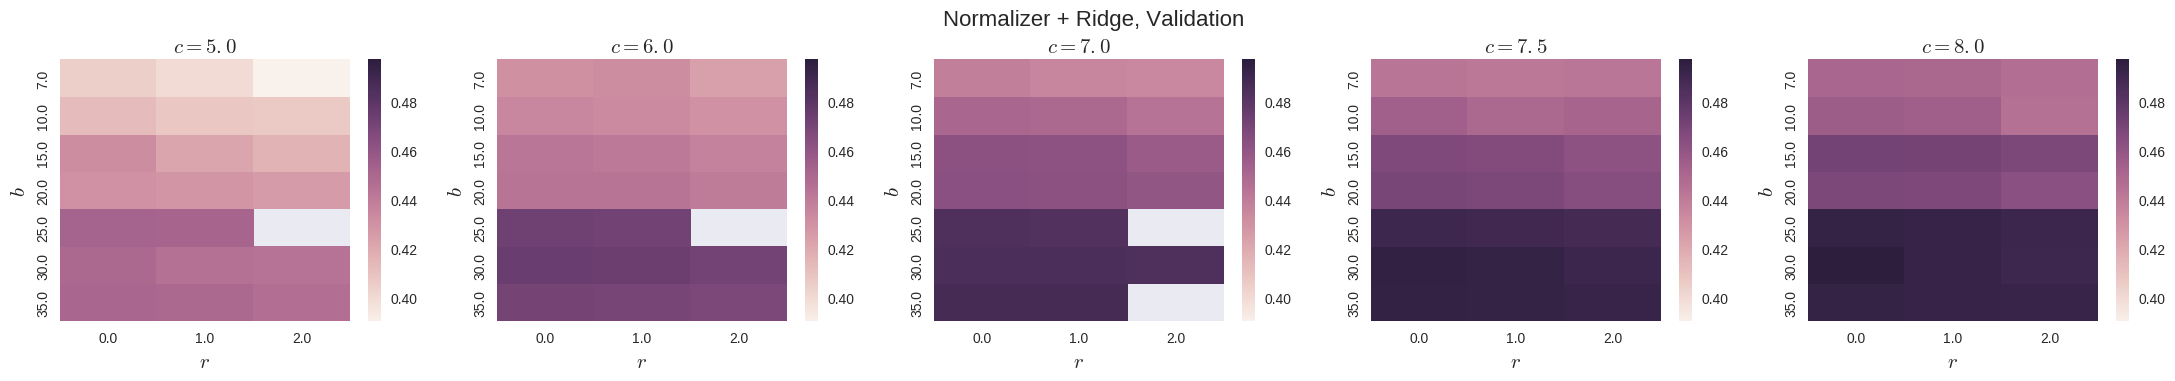

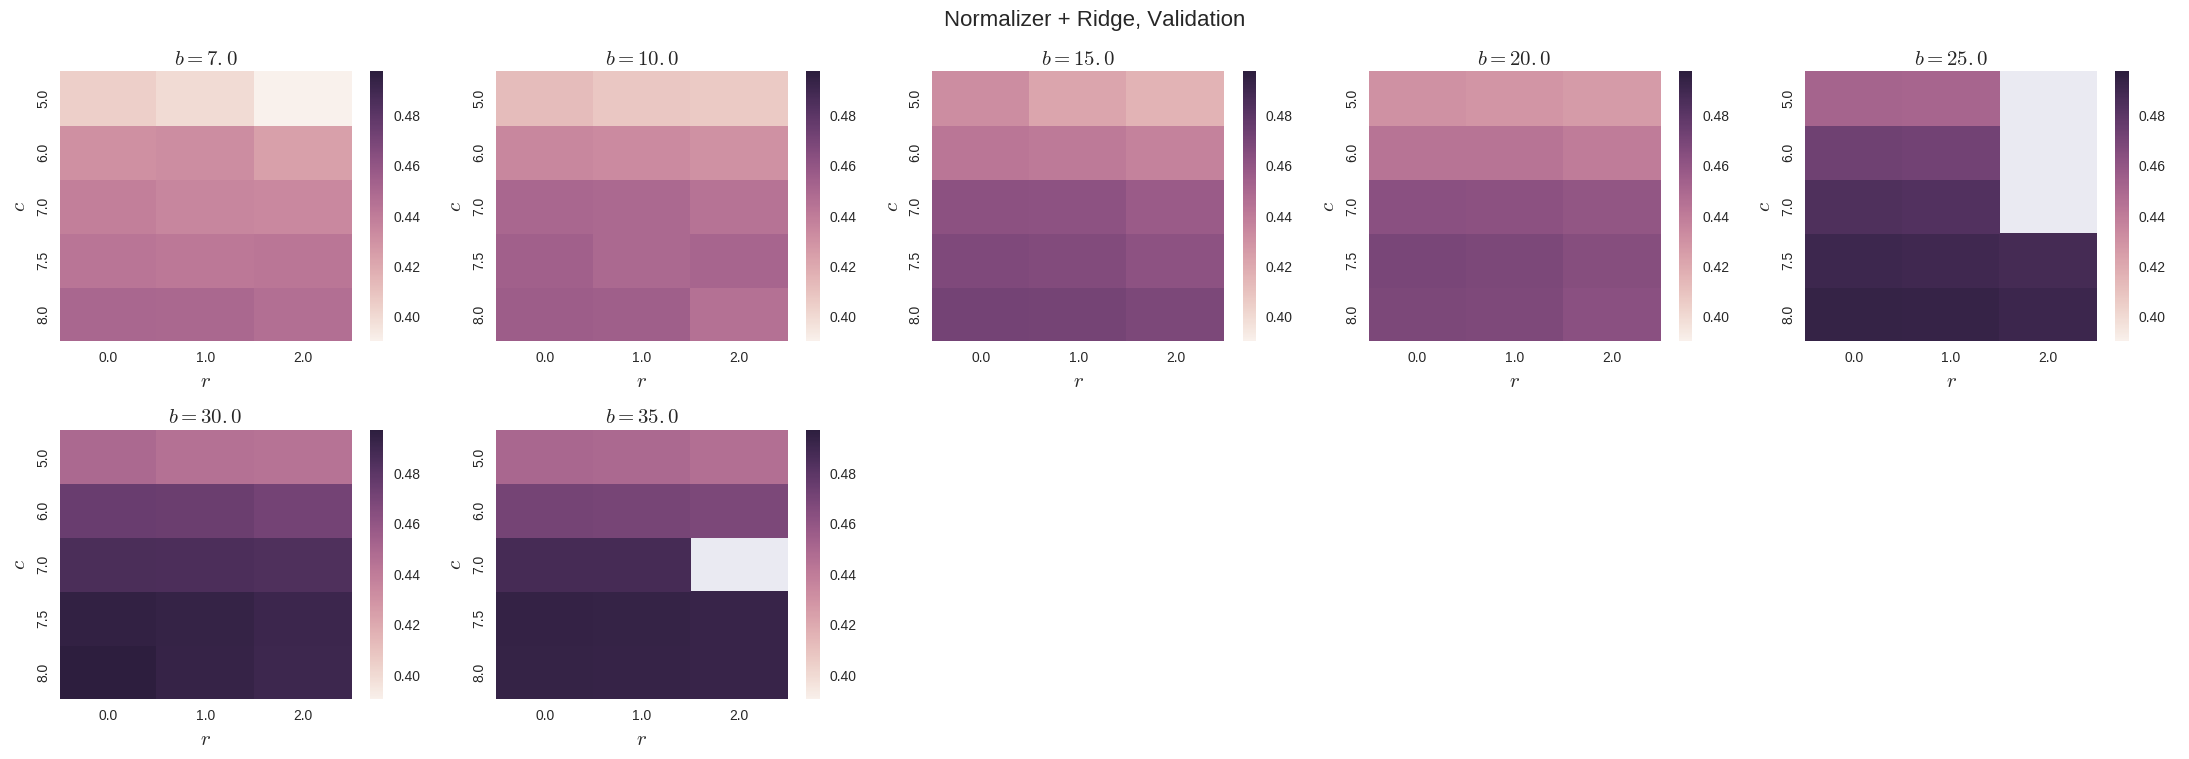

The best:
*backboneatoms-s0-b30-c8-r0--residue_dependent--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native   85.2389    83.6372      79.0487      79.4381   
Top 1                    0.039823          0            0   0.00442478   
Top 5                    0.106195  0.0353982    0.0353982    0.0176991   
Mean score for top 1      7.30712   0.536439     0.440379     0.475566   
Mean loss score          -4.68052   0.176165      0.16891     0.164611   
Mean Pearson             0.495486  -0.535345    -0.552131    -0.552658   
Mean Spearman            0.424751  -0.423374    -0.442304     -0.44297   
PMCC                      0.38509  -0.645681    -0.630865    -0.634144   
SMCC                     0.611692  -0.655961    -0.643064    -0.641797   
wmPMCC                   0.535708  -0.592594    -0.604877    -0.608485   
wmSMCC                   0.442103  -0.445585    -0.465026     -0.46571   
sum Z-score              -115.974    24.1632      48.7303      36.2203   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      79.7168        238.128            72.7522   
Top 1                              0              0          0.0221239   
Top 5                      0.0309735              0            0.10177   
Mean score for top 1        0.342434        7.30712           0.578098   
Mean loss score             0.133988         56.528           0.176211   
Mean Pearson               -0.556107       0.495486          -0.593667   
Mean Spearman              -0.449946       0.424761          -0.483941   
PMCC                       -0.617566        0.38509          -0.667185   
SMCC                       -0.632427       0.611693          -0.676594   
wmPMCC                     -0.607972       0.535708          -0.642414   
wmSMCC                     -0.472978       0.442105          -0.504756   
sum Z-score                  46.6459       -115.974             116.53   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                84.7965                81.1195   
Top 1                                0.0309735              0.0309735   
Top 5                                 0.110619               0.119469   
Mean score for top 1                  0.495567               0.538831   
Mean loss score                       0.237239               0.220018   
Mean Pearson                         -0.580603              -0.591097   
Mean Spearman                        -0.479091              -0.488068   
PMCC                                  -0.65463              -0.663263   
SMCC                                 -0.666354              -0.669851   
wmPMCC                               -0.628793              -0.640246   
wmSMCC                                -0.50126              -0.509555   
sum Z-score                            154.141                158.229   

                        GDT-HA-score-backwards  
Mean rank of the native                82.3584  
Top 1                                0.0221239  
Top 5                                 0.110619  
Mean score for top 1                  0.389683  
Mean loss score                       0.213671  
Mean Pearson                         -0.576675  
Mean Spearman                        -0.484195  
PMCC                                 -0.642472  
SMCC                                 -0.658533  
wmPMCC                               -0.624655  
wmSMCC                               -0.506816  
sum Z-score                            164.323

In [24]:
plot_results(results_val,
             'Normalizer + Ridge', correlation_score,
             params, info='Validation', num_cols=5, figsize=1.1)

## Backup

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

### Save dump

In [25]:
if len(results_train) == 0:
    raise Exception('Empty results')
joblib.dump((results_train, results_val), theNotebook + '.pkl')

['benchmark_backboneatoms_residue_dependent.pkl']

### Load from dump

In [10]:
results_train, results_val = joblib.load(theNotebook + '.pkl')